# Translation of a discrete 1D signal


#### wave equation

$$
\frac{\partial^2 u}{\partial t^2}
 = 
 v^2 \frac{\partial^2 u}{\partial x^2}
$$


##### simple sine solution

$$
u(x, t) = \sin\left( \frac{2 \pi x}{\lambda} -2\pi f t\right)
= \sin\left( 2 \pi f \, ( \frac{x}{v(f)} -t) \right)
$$

$$\lambda = \dfrac{v}{f}$$
##### plane wave per mode



$$ 
u_f(x,t) 
= 
 A \exp(- 2\pi i f \left[ \frac{x}{v(f)} - t \right] )
 +
 B \exp(- 2\pi i f \left[ \frac{x}{v(f)} + t \right] )
$$


In [1]:
%matplotlib inline

import numpy as np
import scipy.fft as ft
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tck
import scipy.interpolate as interp

rng = np.random.default_rng()

In [2]:
class TravelSignal:
    """
    Model an arbitrary signal that can be translated to another position and time.
    """

    def __init__(self, signal, sample_rate, t_0 = 0, x_0 = 0, periodic=True):
        assert periodic, "Non-periodic signal is not yet supported"

        self.raw = signal

        self.sample_rate = sample_rate # Hz
        self.sample_length = len(self.raw)
        self.time_length = self.sample_length*sample_rate # s
        
        self.x_0 = x_0
        self.t_0 = t_0

        # choose interpolation method
        if not interp1d_kw:
            self.interp_f = None

        else:
            # offload interpolation to scipy.interpolate
            import scipy.interpolate as interp

            interp1d_kw_defaults = {
                "copy": False,
                "kind": 'linear',
                "assume_sorted": True,
                "bounds_error": True
            }

            if self.periodic:
                interp1d_kw_defaults['bounds_error'] = False
                interp1d_kw_defaults['fill_value'] = (self.raw[-1], self.raw[0])
                
            # merge kwargs
            if interp1d_kw is not True:
                interp1d_kw = { **interp1d_kw_defaults, **interp1d_kw }

            self.interp_f = interp.interp1d(
                np.arange(0, self.sample_length),
                self.raw,
                **interp1d_kw
            )
        else:
            self.interp_f = None
        
    def __len__(self):
        return self.sample_length
        
    def __call__(self, t_f = None, x_f = None, **kwargs):
        """
        Allow this class to be used as a function.
        """
        return self._translate(t_f, x_f, **kwargs)[0]
    
    def _translate(self, t_f = None, x_f = None, t_0 = None, x_0 = None, velocity = None):
        """
        Translate the signal from (t_0, x_0) to (t_f, x_f) with optional velocity.
        
        Returns the signal at (t_f, x_f)
        """
        
        if t_0 is None:
            t_0 = self.t_0
        
        if velocity is None:
            velocity = 1


        ## spatial offset
        if x_f is None:
            spatial_time_offset = 0
        else:
            x_f = np.asarray(x_f)
            if x_0 is None:
                x_0 = self.x_0

            spatial_time_offset = np.sum(np.sqrt( (x_f - x_0)**2 )/velocity)

        ## temporal offset
        if t_f is None:
            temporal_time_offset = 0
        else:
            t_f = np.asarray(t_f)
                
            if t_0 is None:
                t_0 = self.t_0
        
            temporal_time_offset = t_f - t_0

        # total offset
        total_time_offset = spatial_time_offset + temporal_time_offset

        # periodic signal
        n_offset = (total_time_offset * sample_rate ) % self.sample_length

        # offload to scipy interpolation
        if self.interp_f:
            amplitude = self.interp_f(n_offset)
        else:
            # self written interpolation
            n_offset_eps, n_offset_int = np.modf(n_offset)
            n_offset_int = n_offset.astype(int)

            if True:
                amplitude = (1-n_offset_eps) * self.raw[n_offset_int] \
                            + n_offset_eps * self.raw[(n_offset_int + 1) % self.sample_length]

            else:
                amplitude = self.raw[n_offset_int]

        
        return amplitude, total_time_offset

# Testing:

### Interpolation: Sine wave

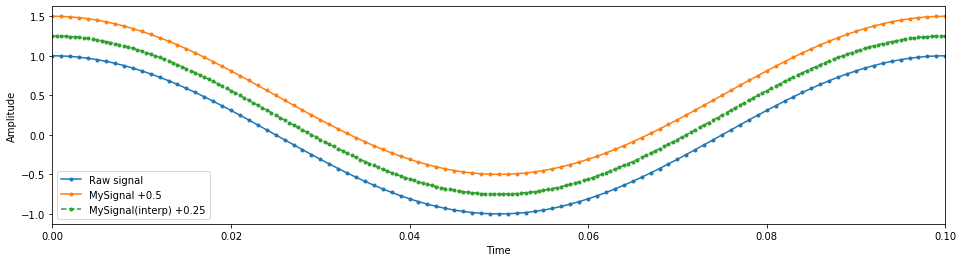

In [3]:
# Sine wave
sample_rate = 1e3 # Hz
f_sine = 10
time   = np.arange(0, 1, 1/(sample_rate)) #s
time2   = np.arange(0, 1, 1/(sample_rate*2)) #s
phase_offset = 0

signal_func = lambda t: np.cos(2*np.pi*f_sine*t + phase_offset)

mysignal = TravelSignal(signal_func(time), sample_rate)

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(time,  signal_func(time),    '.-',  label="Raw signal")
ax.plot(time,  mysignal(time)+0.5,   '.-',  label="MySignal +0.5")
ax.plot(time2, mysignal(time2)+0.25, '.--', label="MySignal(interp) +0.25")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time")
ax.set_xlim(0, 1/f_sine)
ax.legend()
plt.show();

### Extrapolation: Sine wave

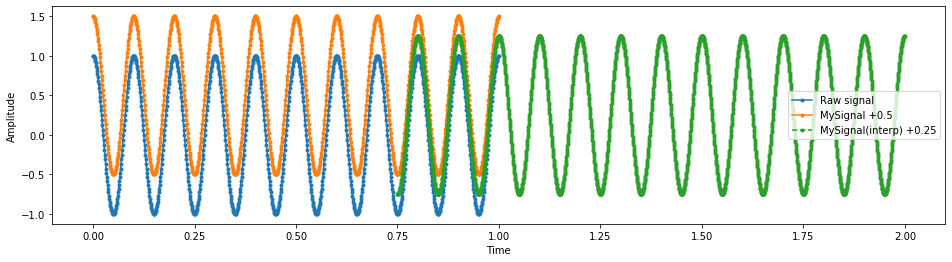

In [4]:
# Sine wave
sample_rate = 1e3 # Hz
f_sine = 10
time   = np.arange(0, 1, 1/(sample_rate)) #s
time2   = np.arange(3/4, 2, 1/(sample_rate*2)) #s
phase_offset = 0

signal_func = lambda t: np.cos(2*np.pi*f_sine*t + phase_offset)

mysignal = TravelSignal(signal_func(time), sample_rate)

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(time,  signal_func(time),    '.-',  label="Raw signal")
ax.plot(time,  mysignal(time)+0.5,   '.-',  label="MySignal +0.5")
ax.plot(time2, mysignal(time2)+0.25, '.--', label="MySignal(interp) +0.25")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time")
ax.legend()
plt.show();

### Interpolation: Delta function

P Raw S1 S2
a 1.0 1.0 0.9130434782608696
T 0.4666666666666667 0.4666666666666667 0.4782608695652174
[0.         0.03333333 0.06666667 0.1        0.13333333 0.16666667
 0.2        0.23333333 0.26666667 0.3        0.33333333 0.36666667
 0.4        0.43333333 0.46666667 0.5        0.53333333 0.56666667
 0.6        0.63333333 0.66666667 0.7        0.73333333 0.76666667
 0.8        0.83333333 0.86666667 0.9        0.93333333 0.96666667] [0.         0.01449275 0.02898551 0.04347826 0.05797101 0.07246377
 0.08695652 0.10144928 0.11594203 0.13043478 0.14492754 0.15942029
 0.17391304 0.1884058  0.20289855 0.2173913  0.23188406 0.24637681
 0.26086957 0.27536232 0.28985507 0.30434783 0.31884058 0.33333333
 0.34782609 0.36231884 0.37681159 0.39130435 0.4057971  0.42028986
 0.43478261 0.44927536 0.46376812 0.47826087 0.49275362 0.50724638
 0.52173913 0.53623188 0.55072464 0.56521739 0.57971014 0.5942029
 0.60869565 0.62318841 0.63768116 0.65217391 0.66666667 0.68115942
 0.69565217 0.71014493 0.7246

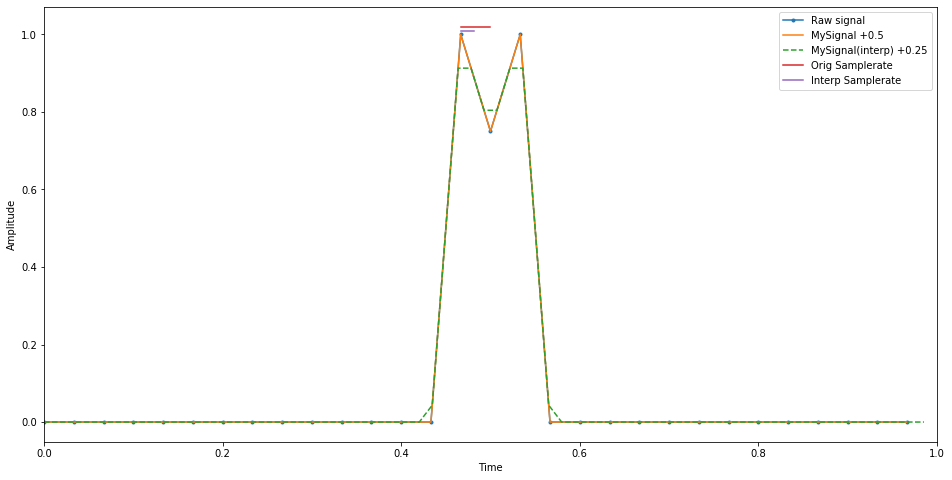

In [6]:
## 1d signal: Delta peak with time interval
sample_rate = 3e1 # Hz
interp_sample_rate = 2.3*sample_rate
time   = np.arange(0, 1, 1/sample_rate) #s
time2  = np.arange(0, 1, 1/(interp_sample_rate)) #s

signal = np.zeros(len(time))
signal[len(signal)//2-1] = 1
signal[len(signal)//2] = 0.75
signal[len(signal)//2+1] = 1

mysignal = TravelSignal(signal, sample_rate+20)
time_signal,  time_offsets  = mysignal._translate(time)
time2_signal, time2_offsets = mysignal._translate(time2)

raw_max_idx = np.argmax(signal)
my_max_idx  = np.argmax(mysignal(time))
my2_max_idx = np.argmax(mysignal(time2))


fig, ax = plt.subplots(1,1,sharex=True, figsize=(16,8))
ax.plot(time,  mysignal.raw,  '.-', label="Raw signal")
ax.plot(time,  time_signal,   '-',  label="MySignal +0.5")
ax.plot(time2, time2_signal,  '--', label="MySignal(interp) +0.25")
ax.plot(np.array([0, 1/sample_rate]) + time[raw_max_idx], [1.02, 1.02], label="Orig Samplerate")
ax.plot(np.array([0, 1/interp_sample_rate]) + time[raw_max_idx], [1.01, 1.01], label="Interp Samplerate")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time")
ax.set_xlim(0, 1)
ax.legend()


print("P",     "Raw",               "S1",                       "S2")
print("a",     signal[raw_max_idx], mysignal(time)[my_max_idx], mysignal(time2)[my2_max_idx])
print("T",     time[raw_max_idx],   time[my_max_idx],           time2[my2_max_idx])

print(time_offsets, time2_offsets)
plt.show();